In [1]:
import pandas as pd
import numpy as np
import warnings
import os
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
"""
sns 相关设置
@return:
"""
# 声明使用 Seaborn 样式
sns.set()
# seaborn的绘图风格
sns.set_style("whitegrid")
# 预置环境
sns.set_context('talk')
# 中文字体设置-黑体
plt.rcParams['font.sans-serif'] = ['SimHei']
# 解决保存图像是负号'-'显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False
# 解决Seaborn中文显示问题并调整字体大小
sns.set(font='SimHei')

In [2]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
# 读取数据
data = pd.read_csv('./data/data_for_model.csv')
y_train = pd.read_csv('./data/label_for_model.csv')
# 通过调整数据类型，节省内存占用空间
data = reduce_mem_usage(data)

Memory usage of dataframe is 507151136.00 MB
Memory usage after optimization is: 143042816.00 MB
Decreased by 71.8%


In [4]:
from sklearn.model_selection import KFold
# 分离数据集，方便进行交叉验证
X_train = data.loc[data['sample']=='train', :]
X_test = data.loc[data['sample']=='test', :]
# y_train = y_train['isDefault']

# 5折交叉验证
folds = 5
seed = 2022
kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

In [5]:
X_train.shape

(612742, 78)

In [6]:
"""对训练集数据进行划分，分成训练集和验证集，并进行相应的操作"""
from sklearn.model_selection import train_test_split
import lightgbm as lgb
# 数据集划分
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=seed)
train_matrix = lgb.Dataset(X_train_split, label=y_train_split)
valid_matrix = lgb.Dataset(X_val, label=y_val)

params = {
            'boosting_type': 'gbdt',    # 指定弱学习器的类型为GBDT
            'objective': 'binary',   # 学习目标：二分类
            'learning_rate': 0.1,
            'metric': 'auc',
            'min_child_weight': 1e-3,
            'num_leaves': 31,    # 指定叶子的个数，默认值为31
            'max_depth': -1,     # 指定树的最大深度，默认值为-1，表示不做限制
            'reg_lambda': 0,
            'reg_alpha': 0,
            'feature_fraction': 1,  # 构建弱学习器时，对特征随机采样的比例，默认值为1
            'bagging_fraction': 1,  # 默认值1，指定采样出bagging_fraction * n_samples个样本用于训练弱学习器
            'bagging_freq': 0,   # 数值型，默认值0，表示禁用样本采样。如果设置为整数k，则每迭代k次执行一次采样
            'seed': 2022,
            'nthread': 8,
            'verbose': -1,
}

"""使用训练集数据进行模型训练"""
model = lgb.train(params, train_set=train_matrix, valid_sets=valid_matrix, num_boost_round=20000, verbose_eval=100, early_stopping_rounds=200)
# verbose_eval打印评估信息的迭代间隔

Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.727253
[200]	valid_0's auc: 0.728228
[300]	valid_0's auc: 0.728502
[400]	valid_0's auc: 0.72864
[500]	valid_0's auc: 0.728603
[600]	valid_0's auc: 0.728506
Early stopping, best iteration is:
[425]	valid_0's auc: 0.728755


未调参前lightgbm单模型在验证集上的AUC：0.7287547849205032


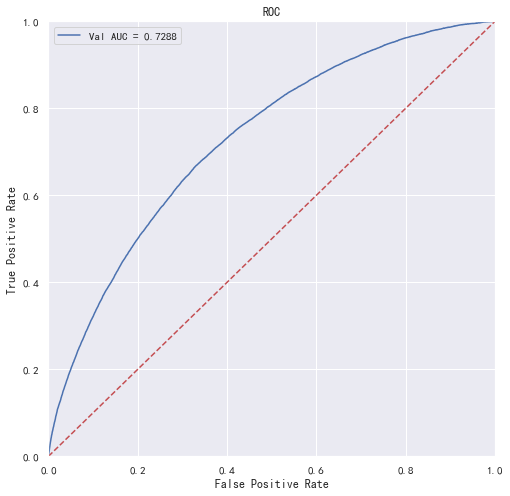

In [7]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score

"""预测并计算roc的相关指标"""
val_pre_lgb = model.predict(X_val, num_iteration=model.best_iteration)
fpr, tpr, threshold = metrics.roc_curve(y_val, val_pre_lgb)
roc_auc = metrics.auc(fpr, tpr)
print('未调参前lightgbm单模型在验证集上的AUC：{}'.format(roc_auc))
"""画出roc曲线图"""
plt.figure(figsize=(8, 8))
plt.title('Validation ROC')
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.4f' % roc_auc)
plt.ylim(0,1)
plt.xlim(0,1)
plt.legend(loc='best')
plt.title('ROC')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
# 画出对角线
plt.plot([0,1],[0,1],'r--')
plt.show()

In [8]:
import lightgbm as lgb
"""使用lightgbm 5折交叉验证进行建模预测"""
cv_scores = []
for i, (train_index, valid_index) in enumerate(kf.split(X_train, y_train)):
    print('************************************ {} ************************************'.format(str(i+1)))
    X_train_split, y_train_split, X_val, y_val = X_train.iloc[train_index], y_train.iloc[train_index], X_train.iloc[valid_index], y_train.iloc[valid_index]
    
    train_matrix = lgb.Dataset(X_train_split, label=y_train_split)
    valid_matrix = lgb.Dataset(X_val, label=y_val)

    params = {
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'learning_rate': 0.1,
                'metric': 'auc',
                'min_child_weight': 1e-3,
                'num_leaves': 31,
                'max_depth': -1,
                'reg_lambda': 0,
                'reg_alpha': 0,
                'feature_fraction': 1,
                'bagging_fraction': 1,
                'bagging_freq': 0,
                'seed': 2022,
                'nthread': 8,
                'verbose': -1,
    }
    
    model = lgb.train(params, train_set=train_matrix, num_boost_round=20000, valid_sets=valid_matrix, verbose_eval=100, early_stopping_rounds=200)
    val_pred = model.predict(X_val, num_iteration=model.best_iteration)
    
    cv_scores.append(roc_auc_score(y_val, val_pred))
    print(cv_scores)

print("lgb_scotrainre_list:{}".format(cv_scores))
print("lgb_score_mean:{}".format(np.mean(cv_scores)))
print("lgb_score_std:{}".format(np.std(cv_scores)))

************************************ 1 ************************************
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.727375
[200]	valid_0's auc: 0.728522
[300]	valid_0's auc: 0.728993
[400]	valid_0's auc: 0.728917
[500]	valid_0's auc: 0.72885
Early stopping, best iteration is:
[360]	valid_0's auc: 0.729035
[0.7290349344626855]
************************************ 2 ************************************
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.727768
[200]	valid_0's auc: 0.728821
[300]	valid_0's auc: 0.728994
[400]	valid_0's auc: 0.728995
Early stopping, best iteration is:
[274]	valid_0's auc: 0.729158
[0.7290349344626855, 0.7291575879104765]
************************************ 3 ************************************
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.728686
[200]	valid_0's auc: 0.730136
[300]	valid_0's auc: 0.730586
[400]	valid_0's auc: 0.730779
[500]

In [9]:
"""尝试贝叶斯调参"""
from sklearn.model_selection import cross_val_score   # 交叉验证

"""定义优化函数"""
def rf_cv_lgb(num_leaves, max_depth, bagging_fraction, feature_fraction, bagging_freq, min_data_in_leaf, 
              min_child_weight, min_split_gain, reg_lambda, reg_alpha):
    # 建立模型
    model_lgb = lgb.LGBMClassifier(boosting_type='gbdt', objective='binary', metric='auc',
                                   learning_rate=0.1, n_estimators=5000,
                                   num_leaves=int(num_leaves), max_depth=int(max_depth), 
                                   bagging_fraction=round(bagging_fraction, 2), feature_fraction=round(feature_fraction, 2),
                                   bagging_freq=int(bagging_freq), min_data_in_leaf=int(min_data_in_leaf),
                                   min_child_weight=min_child_weight, min_split_gain=min_split_gain,
                                   reg_lambda=reg_lambda, reg_alpha=reg_alpha,
                                   n_jobs= 8
                                  )
    # cv：int 交叉验证的方法
    val = cross_val_score(model_lgb, X_train_split, y_train_split, cv=5, scoring='roc_auc').mean()
    
    return val

In [10]:
from bayes_opt import BayesianOptimization
"""定义优化参数"""
bayes_lgb = BayesianOptimization(
    rf_cv_lgb, 
    {
        'num_leaves':(10, 200),
        'max_depth':(3, 20),
        'bagging_fraction':(0.5, 1.0),
        'feature_fraction':(0.5, 1.0),
        'bagging_freq':(0, 100),
        'min_data_in_leaf':(10,100),
        'min_child_weight':(0, 10),
        'min_split_gain':(0.0, 1.0),
        'reg_alpha':(0.0, 10),
        'reg_lambda':(0.0, 10),
    }
)

"""开始优化"""
bayes_lgb.maximize(n_iter=10)

|   iter    |  target   | baggin... | baggin... | featur... | max_depth | min_ch... | min_da... | min_sp... | num_le... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------------------------------------------
[LightGBM] [Warning] feature_fraction is set=0.69, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.69
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] bagging_fraction is set=0.98, subsample=1.0 will be ignored. Current value: bagging_fraction=0.98
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] feature_fraction is set=0.69, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.69
[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min

[LightGBM] [Warning] feature_fraction is set=0.95, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.95
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] bagging_fraction is set=0.71, subsample=1.0 will be ignored. Current value: bagging_fraction=0.71
[LightGBM] [Warning] bagging_freq is set=96, subsample_freq=0 will be ignored. Current value: bagging_freq=96
[LightGBM] [Warning] feature_fraction is set=0.95, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.95
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] bagging_fraction is set=0.71, subsample=1.0 will be ignored. Current value: bagging_fraction=0.71
[LightGBM] [Warning] bagging_freq is set=96, subsample_freq=0 will be ignored. Current value: bagging_freq=96
[LightGBM] [Warning] feature_fraction is set=0

[LightGBM] [Warning] feature_fraction is set=0.63, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.63
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] bagging_fraction is set=0.55, subsample=1.0 will be ignored. Current value: bagging_fraction=0.55
[LightGBM] [Warning] bagging_freq is set=93, subsample_freq=0 will be ignored. Current value: bagging_freq=93
[LightGBM] [Warning] feature_fraction is set=0.63, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.63
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] bagging_fraction is set=0.55, subsample=1.0 will be ignored. Current value: bagging_fraction=0.55
[LightGBM] [Warning] bagging_freq is set=93, subsample_freq=0 will be ignored. Current value: bagging_freq=93
[LightGBM] [Warning] feature_fraction is set=0

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] bagging_fraction is set=0.78, subsample=1.0 will be ignored. Current value: bagging_fraction=0.78
[LightGBM] [Warning] bagging_freq is set=99, subsample_freq=0 will be ignored. Current value: bagging_freq=99
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] bagging_fraction is set=0.78, subsample=1.0 will be ignored. Current value: bagging_fraction=0.78
[LightGBM] [Warning] bagging_freq is set=99, subsample_freq=0 will be ignored. Current value: bagging_freq=99
|  10       |  0.73     |  0.778    |  99.74    | 

[LightGBM] [Warning] feature_fraction is set=0.56, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.56
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
|  13       |  0.728    |  0.9454   |  0.474    |  0.5555   |  19.73    |  8.853    |  96.26    |  0.6824   |  184.8    |  3.39     |  2.16     |
[LightGBM] [Warning] feature_fraction is set=0.92, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.92
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] bagging_fraction is set=0.96, subsample=1.0 will be ignored. Current value: bagging_fraction=0.96
[LightGBM] [

In [11]:
"""显示优化结果"""
bayes_lgb.max

{'target': 0.7300197044976127,
 'params': {'bagging_fraction': 0.777985395309857,
  'bagging_freq': 99.7403000467068,
  'feature_fraction': 0.7021910041549642,
  'max_depth': 16.067693667037968,
  'min_child_weight': 6.24549283505912,
  'min_data_in_leaf': 97.93108023493242,
  'min_split_gain': 0.7357651265476995,
  'num_leaves': 12.713791364827479,
  'reg_alpha': 5.101112914620568,
  'reg_lambda': 6.128014307594036}}

In [12]:
"""调整一个较小的学习率，并通过cv函数确定当前最优的迭代次数"""
base_params_lgb = {
                    'boosting_type': 'gbdt',
                    'objective': 'binary',
                    'metric': 'auc',
                    'learning_rate': 0.01,
                    'num_leaves': 13,
                    'max_depth': 16,
                    'min_data_in_leaf': 98,
                    'min_child_weight':6.2,
                    'bagging_fraction': 0.78,
                    'feature_fraction': 0.69,
                    'bagging_freq': 99,
                    'reg_lambda': 6,
                    'reg_alpha': 5,
                    'min_split_gain': 0.74,
                    'nthread': 8,
                    'seed': 2022,
                    'verbose': -1,
}

cv_result_lgb = lgb.cv(
    train_set=train_matrix,
    early_stopping_rounds=1000, 
    num_boost_round=20000,
    nfold=5,
    stratified=True,
    shuffle=True,
    params=base_params_lgb,
    metrics='auc',
    seed=0
)

print('迭代次数{}'.format(len(cv_result_lgb['auc-mean'])))
print('最终模型的AUC为{}'.format(max(cv_result_lgb['auc-mean'])))

迭代次数11065
最终模型的AUC为0.7315979783976564


[LightGBM] [Info] Number of positive: 95567, number of negative: 394627
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6242
[LightGBM] [Info] Number of data points in the train set: 490194, number of used features: 73
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.194958 -> initscore=-1.418113
[LightGBM] [Info] Start training from score -1.418113
Training until validation scores don't improve for 200 rounds
[1000]	valid_0's auc: 0.728542
[2000]	valid_0's auc: 0.732507
[3000]	valid_0's auc: 0.7338
[4000]	valid_0's auc: 0.734586
[5000]	valid_0's auc: 0.735069
[6000]	valid_0's auc: 0.735412
[7000]	valid_0's auc: 0.735723
[8000]	valid_0's auc: 0.735877
Early stopping, best iteration is:
[8768]	valid_0's auc: 0.735972
调参后lightgbm单模型在验证集上的AUC：0.7359716796861528


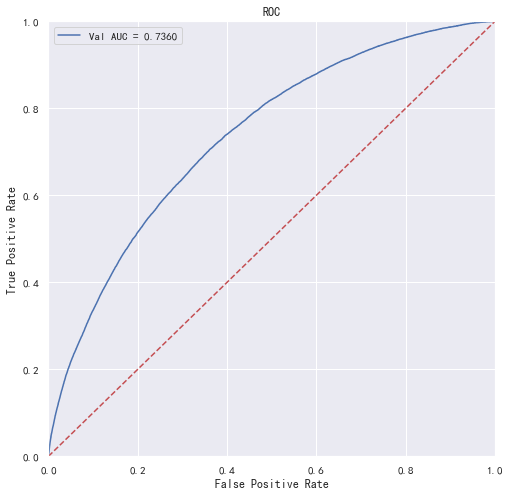

In [15]:
base_params_lgb = {
                    'boosting_type': 'gbdt',
                    'objective': 'binary',
                    'metric': 'auc',
                    'learning_rate': 0.01,
                    'num_leaves': 13,
                    'max_depth': 16,
                    'min_data_in_leaf': 98,
                    'min_child_weight':6.2,
                    'bagging_fraction': 0.78,
                    'feature_fraction': 0.69,
                    'bagging_freq': 99,
                    'reg_lambda': 6,
                    'reg_alpha': 5,
                    'min_split_gain': 0.74,
                    'nthread': 8,
                    'seed': 2022,
}

"""使用训练集数据进行模型训练"""
final_model_lgb = lgb.train(base_params_lgb, train_set=train_matrix, valid_sets=valid_matrix, num_boost_round=11065, verbose_eval=1000, early_stopping_rounds=200)

"""预测并计算roc的相关指标"""
val_pre_lgb = final_model_lgb.predict(X_val)
fpr, tpr, threshold = metrics.roc_curve(y_val, val_pre_lgb)
roc_auc = metrics.auc(fpr, tpr)
print('调参后lightgbm单模型在验证集上的AUC：{}'.format(roc_auc))
"""画出roc曲线图"""
plt.figure(figsize=(8, 8))
plt.title('Validation ROC')
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.4f' % roc_auc)
plt.ylim(0,1)
plt.xlim(0,1)
plt.legend(loc='best')
plt.title('ROC')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
# 画出对角线
plt.plot([0,1],[0,1],'r--')
plt.show()

In [16]:
"""保存模型到本地"""
# 保存模型
import pickle
pickle.dump(final_model_lgb, open('./data/model_lgb_best.pkl', 'wb'))

In [18]:
# 加载模型并获取测试结果
import pickle
with open('./data/model_lgb_best.pkl','rb') as f:
    test_model = pickle.load(f)
    y_test_pred = test_model.predict(X_test)
y_test_pred

array([0.07343854, 0.33964044, 0.55304414, ..., 0.2233054 , 0.23838726,
       0.02193524])

In [23]:
id=np.arange(800000, 1000000)

(200000,)

In [25]:
df = pd.DataFrame(zip(id, y_test_pred), columns=['id', 'isDefault'])

In [26]:
df

,id,isDefault
0,800000,0.073439
1,800001,0.339640
2,800002,0.553044
3,800003,0.294187
4,800004,0.372699
...,...,...
199995,999995,0.200464
199996,999996,0.036680
199997,999997,0.223305
199998,999998,0.238387


In [28]:
df.to_csv('./data/out_lgb.csv', index=False)

<Figure size 864x432 with 0 Axes>

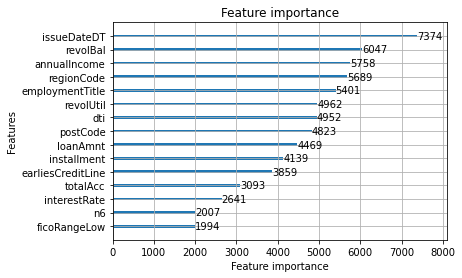

In [14]:
"""绘制特征重要性"""
from lightgbm import plot_importance
# 显示重要特征，max_num_features 指定显示多少个特征
import pickle
import matplotlib.pyplot as plt
with open('./data/model_lgb_best.pkl','rb') as f:
    test_model = pickle.load(f)
    plt.figure(figsize=(12, 6))
    plot_importance(test_model, max_num_features = 15)
    plt.show()
    # 保存feature importance
    importance =test_model.feature_importance(importance_type='split')
    feature_name = test_model.feature_name()
    feature_importance = pd.DataFrame({'feature_name':feature_name,'importance':importance} )
    feature_importance.to_csv('./data/lgb_feature_importance.csv',index=False)


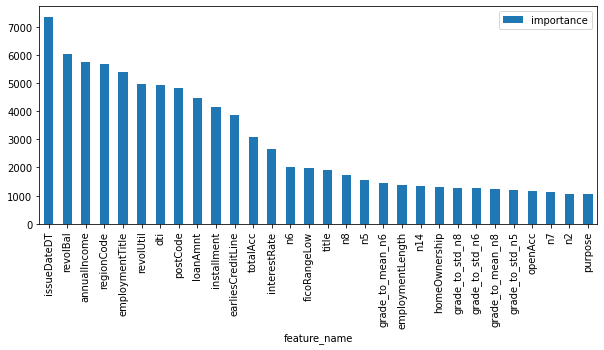

In [33]:
fea_i = pd.read_csv('./data/lgb_feature_importance.csv', index_col=0)
fea_i.sort_values(by='importance',inplace=True, ascending=False)
fea_i[:30].plot(kind="bar",figsize=(10,4))
plt.show()